In [2]:

! pip install ultralytics
! pip install wandb

In [3]:
import os
import random
import pandas as pd
import wandb

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from ultralytics import YOLO
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_images = '/content/drive/MyDrive/mini-project/aquarium_pretrain/train'
train_labels = '/content/drive/mini-project/aquarium_pretrain/train/labels'

val_images = '/content/drive/mini-project/aquarium_pretrain/valid/images'
val_labels = '/content/drive/mini-project/aquarium_pretrain/valid/labels'

test_images = '/content/drive/mini-project/aquarium_pretrain/test/images'
test_labels = '/content/drive/mini-project/aquarium_pretrain/test/labels'

# Define the path to the yaml data file
yaml_path = '/content/drive/mini-project/aquarium_pretrain/data.yaml'


In [6]:
# Define the labels
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


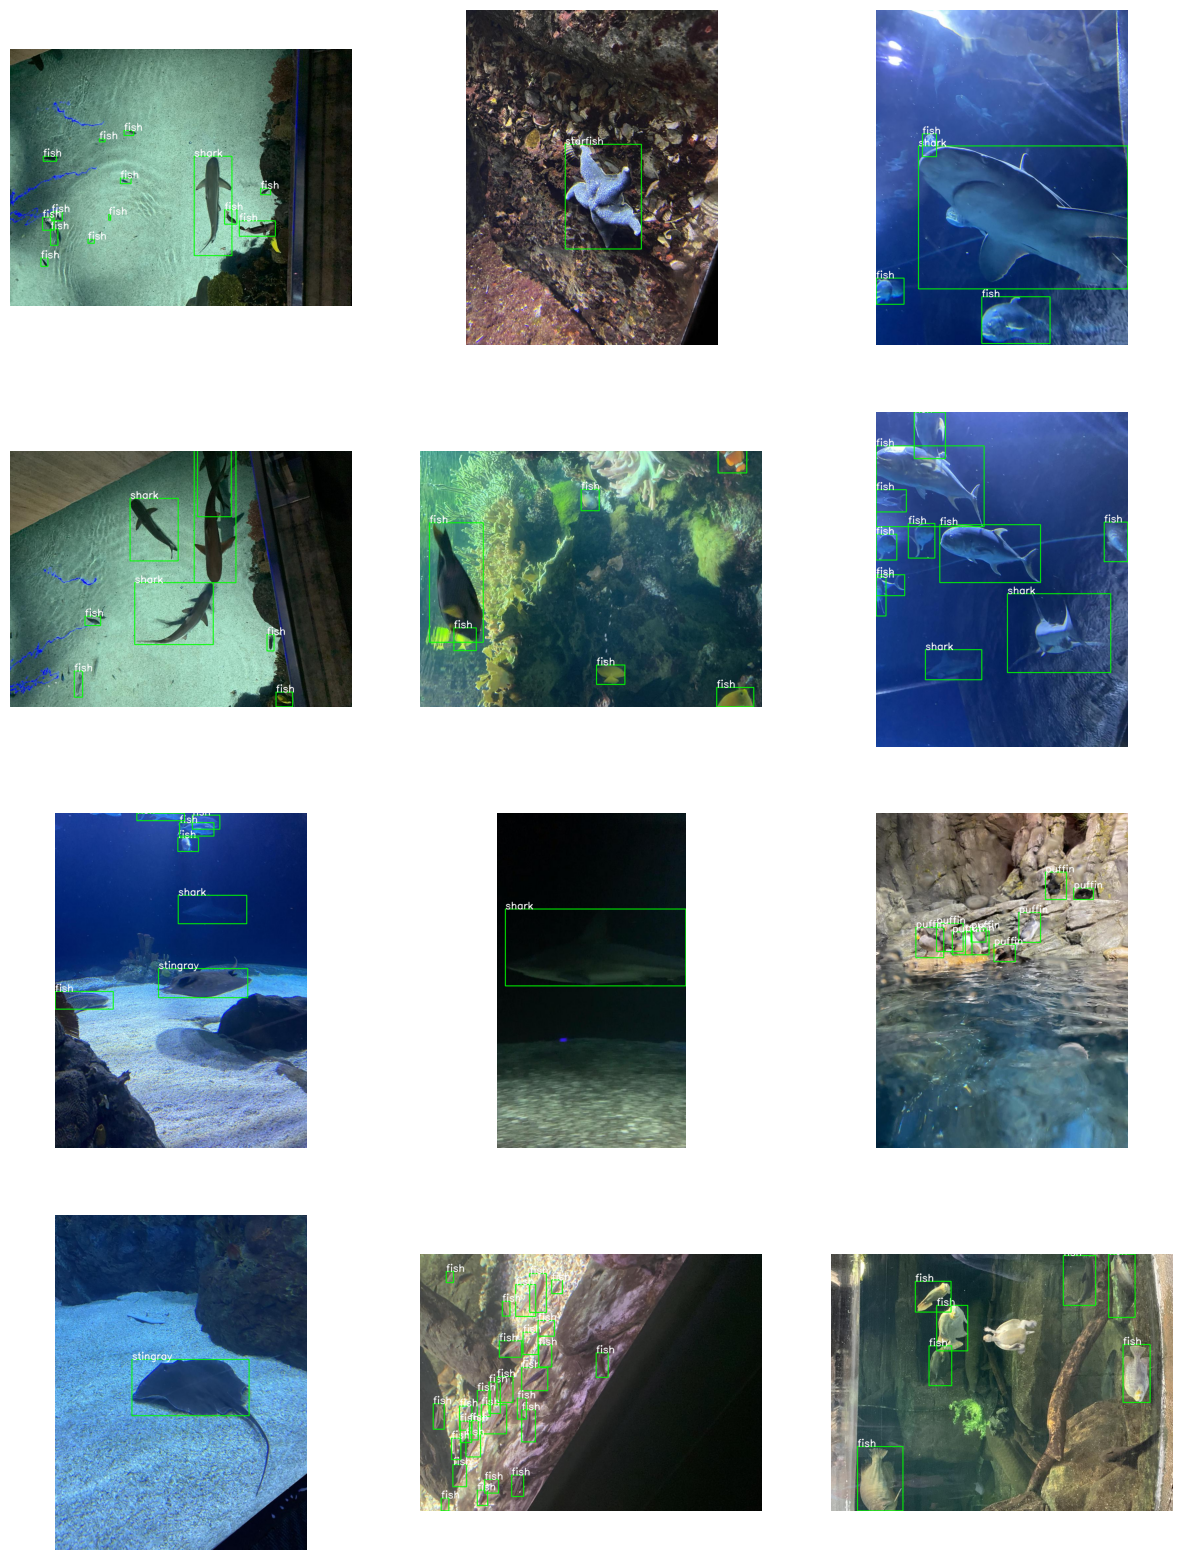

In [7]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))

    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)

    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

# Visualize 6 sample images with bounding boxes
train_images = '/content/drive/MyDrive/mini-project/aquarium_pretrain/train/images'
train_labels = '/content/drive/MyDrive/mini-project/aquarium_pretrain/train/labels'
visualize_image_with_annotation_bboxes(train_images, train_labels)

In [8]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[100])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x768 and 3 channels


In [9]:
# Define the content of the data.yaml file
yaml_content = """
# Path
train: /content/drive/MyDrive/mini-project/aquarium_pretrain/train
val: /content/drive/MyDrive/mini-project/aquarium_pretrain/valid
test: /content/drive/MyDrive/mini-project/aquarium_pretrain/test

# Classes
nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
"""

# Define the file path
file_path = '/content/drive/MyDrive/mini-project/aquarium_pretrain/data.yaml'

# Write the content to the file
with open(file_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)


model training

In [ ]:
# Load a pretrained nano model
model = YOLO('yolov8n.pt')

# Free up GPU memory
torch.cuda.empty_cache()

# Training the model
results = model.train(
    data='/content/drive/MyDrive/mini-project/aquarium_pretrain/data.yaml',
    epochs=100,
    imgsz=(height, width),
    batch =16,
    workers=4,
    project='yolov8n_underwater',
    name='yolov8n_uw')

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/mini-project/aquarium_pretrain/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=None, workers=4, project=yolov8n_underwater, name=yolov8n_uw2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

wandb: Currently logged in as: titanop10303 (lonleo). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/drive/MyDrive/mini-project/aquarium_pretrain/train/labels.cache... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/mini-project/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]

Plotting labels to yolov8n_underwater/yolov8n_uw2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to yolov8n_underwater/yolov8n_uw2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.423      4.206      1.409        221       1024:  21%|██▏       | 6/28 [05:14<18:24, 50.19s/it]